## Python import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf

from keras import layers
from keras import models
from keras import Input
from keras.models import Model
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from keras.utils import to_categorical
from keras import regularizers # L2규제

from tensorflow.keras.preprocessing.image import ImageDataGenerator # data augmentation
from tensorflow.keras.callbacks import LearningRateScheduler # callbacks 설정

from tqdm.notebook import tqdm # 모델학습 진행 시간 파악
import random # random seed를 뽑을때 사용

#gpu사용
config= tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True

In [2]:
print(tf.__version__)

2.3.0


## Load Data

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## EDA

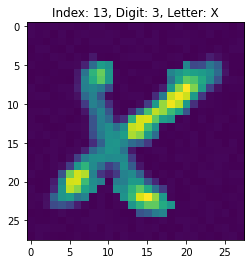

In [4]:
idx = 13
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

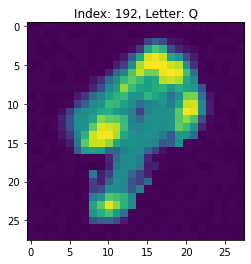

In [5]:
idx = 192
img = test.loc[idx, '0':].values.reshape(28, 28).astype(int)
letter = test.loc[idx, 'letter']

plt.title('Index: %i, Letter: %s'%(idx, letter))
plt.imshow(img)
plt.show()

## Train model

In [6]:
x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
x_train = x_train.reshape(-1, 28, 28, 1)
x_edit=x_train
x_train = x_train/255

y = train['digit']
y_train = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    y_train[i, digit] = 1

In [7]:
threshold=140 #임계값
for i in range(0,2048):
    for j in range(0,28):
        for k in range(0,28):
            if(x_edit[i][j][k][0]<=threshold):
                x_edit[i][j][k][0]=0
            else:
                x_edit[i][j][k][0]=255/255

In [8]:
#결과확인
print(x_edit[2046][7])
print(x_train[2046][7])

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
[[0.00784314]
 [0.        ]
 [0.02352941]
 [0.07058824]
 [0.07843137]
 [0.23921569]
 [0.26666667]
 [0.43921569]
 [0.83529412]
 [0.89803922]
 [0.92941176]
 [0.92156863]
 [0.91764706]
 [0.92156863]
 [0.88627451]
 [0.88627451]
 [0.94117647]
 [0.95294118]
 [0.93333333]
 [0.70980392]
 [0.21960784]
 [0.        ]
 [0.01568627]
 [0.00784314]
 [0.01176471]
 [0.        ]
 [0.00392157]
 [0.00784314]]


---

In [9]:
x_train1 = np.repeat(x_train, 3, axis=1)
x_train2 = np.repeat(x_train1, 3, axis=2)
x_edit1=np.repeat(x_edit, 3, axis=1)
x_edit2=np.repeat(x_edit1, 3, axis=2)

In [10]:
print(x_train2.shape, x_edit2.shape)

(2048, 84, 84, 1) (2048, 84, 84, 1)


In [11]:
def create_cnn_model():
    inputs = Input(shape = (84,84,1))
    
    bn = tf.keras.layers.BatchNormalization()(inputs)
    conv = tf.keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same', activation='relu')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(64, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)
    
    do=tf.keras.layers.Dropout(0.4)(pool)
    
    bn = tf.keras.layers.BatchNormalization()(do)
    conv = tf.keras.layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    do=tf.keras.layers.Dropout(0.4)(pool)
    
    bn = tf.keras.layers.BatchNormalization()(do)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    flatten = tf.keras.layers.Flatten()(pool)

    bn = tf.keras.layers.BatchNormalization()(flatten)
    dense = tf.keras.layers.Dense(1000, activation='relu')(bn)

    bn = tf.keras.layers.BatchNormalization()(dense)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(bn)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [12]:
create_cnn_model().summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 1)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 84, 84, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 84, 84, 64)        1664      
_________________________________________________________________
batch_normalization_1 (Batch (None, 84, 84, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 84, 84, 64)        16448     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 42, 42, 64)       

In [13]:
# 초반 이미지 학습
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1)

model = create_cnn_model()
epochs=100

#model.fit(x_train, y_train, epochs=50)
history = model.fit(
  datagen.flow(x_edit2, y_train, batch_size=16),
  epochs=epochs, 
  steps_per_epoch = x_edit2.shape[0]//16,
  callbacks=[annealer], 
  verbose = 1
)

Epoch 1/100
128/128 [==============================] - 3s 23ms/step - loss: 3.7433 - accuracy: 0.2739
Epoch 2/100
128/128 [==============================] - 3s 23ms/step - loss: 2.6192 - accuracy: 0.3667
Epoch 3/100
128/128 [==============================] - 3s 23ms/step - loss: 2.4850 - accuracy: 0.3916
Epoch 4/100
128/128 [==============================] - 3s 23ms/step - loss: 2.3248 - accuracy: 0.4429
Epoch 5/100
128/128 [==============================] - 3s 22ms/step - loss: 2.2489 - accuracy: 0.4536
Epoch 6/100
128/128 [==============================] - 3s 23ms/step - loss: 2.1742 - accuracy: 0.4585
Epoch 7/100
128/128 [==============================] - 3s 21ms/step - loss: 2.0757 - accuracy: 0.4810
Epoch 8/100
128/128 [==============================] - 3s 20ms/step - loss: 2.0052 - accuracy: 0.4854
Epoch 9/100
128/128 [==============================] - 3s 21ms/step - loss: 1.9614 - accuracy: 0.5107
Epoch 10/100
128/128 [==============================] - 3s 21ms/step - loss: 1.922

128/128 [==============================] - 3s 21ms/step - loss: 0.5953 - accuracy: 0.8682
Epoch 81/100
128/128 [==============================] - 3s 21ms/step - loss: 0.6249 - accuracy: 0.8496
Epoch 82/100
128/128 [==============================] - 3s 21ms/step - loss: 0.6286 - accuracy: 0.8579
Epoch 83/100
128/128 [==============================] - 3s 21ms/step - loss: 0.5891 - accuracy: 0.8726
Epoch 84/100
128/128 [==============================] - 3s 21ms/step - loss: 0.5813 - accuracy: 0.8794
Epoch 85/100
128/128 [==============================] - 3s 21ms/step - loss: 0.5946 - accuracy: 0.8696
Epoch 86/100
128/128 [==============================] - 3s 21ms/step - loss: 0.5913 - accuracy: 0.8687
Epoch 87/100
128/128 [==============================] - 3s 21ms/step - loss: 0.5757 - accuracy: 0.8745
Epoch 88/100
128/128 [==============================] - 3s 21ms/step - loss: 0.5768 - accuracy: 0.8774
Epoch 89/100
128/128 [==============================] - 3s 21ms/step - loss: 0.5859 - 

In [14]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1)

#model = create_cnn_model() #앞에거에 이어서 학습
epochs=80

#model.fit(x_train, y_train, epochs=50)
for i in range(0,10):
    history = model.fit(
      datagen.flow(x_train2, y_train, batch_size=16),
      epochs=epochs, 
      steps_per_epoch = x_train2.shape[0]//16,
      callbacks=[annealer], 
      verbose = 1)

Epoch 1/80
128/128 [==============================] - 3s 21ms/step - loss: 1.7646 - accuracy: 0.5391
Epoch 2/80
128/128 [==============================] - 3s 21ms/step - loss: 1.2426 - accuracy: 0.6826
Epoch 3/80
128/128 [==============================] - 3s 21ms/step - loss: 0.9834 - accuracy: 0.7485
Epoch 4/80
128/128 [==============================] - 3s 21ms/step - loss: 0.8911 - accuracy: 0.7832
Epoch 5/80
128/128 [==============================] - 3s 21ms/step - loss: 0.7945 - accuracy: 0.8101
Epoch 6/80
128/128 [==============================] - 3s 21ms/step - loss: 0.7516 - accuracy: 0.8174
Epoch 7/80
128/128 [==============================] - 3s 21ms/step - loss: 0.6945 - accuracy: 0.8320
Epoch 8/80
128/128 [==============================] - 3s 21ms/step - loss: 0.6295 - accuracy: 0.8477
Epoch 9/80
128/128 [==============================] - 3s 21ms/step - loss: 0.5885 - accuracy: 0.8564
Epoch 10/80
128/128 [==============================] - 3s 21ms/step - loss: 0.5541 - accura

128/128 [==============================] - 3s 21ms/step - loss: 0.1010 - accuracy: 0.9854
Epoch 1/80
128/128 [==============================] - 3s 21ms/step - loss: 1.2632 - accuracy: 0.7119
Epoch 2/80
128/128 [==============================] - 3s 21ms/step - loss: 1.0240 - accuracy: 0.7764
Epoch 3/80
128/128 [==============================] - 3s 21ms/step - loss: 0.8176 - accuracy: 0.8257
Epoch 4/80
128/128 [==============================] - 3s 21ms/step - loss: 0.7117 - accuracy: 0.8477
Epoch 5/80
128/128 [==============================] - 3s 21ms/step - loss: 0.6068 - accuracy: 0.8677
Epoch 6/80
128/128 [==============================] - 3s 21ms/step - loss: 0.5333 - accuracy: 0.8926
Epoch 7/80
128/128 [==============================] - 3s 21ms/step - loss: 0.5813 - accuracy: 0.8647
Epoch 8/80
128/128 [==============================] - 3s 21ms/step - loss: 0.6289 - accuracy: 0.8647
Epoch 9/80
128/128 [==============================] - 3s 21ms/step - loss: 0.5454 - accuracy: 0.8901
E

Epoch 80/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1191 - accuracy: 0.9863
Epoch 1/80
128/128 [==============================] - 3s 21ms/step - loss: 0.7911 - accuracy: 0.8145
Epoch 2/80
128/128 [==============================] - 3s 22ms/step - loss: 1.2627 - accuracy: 0.7480
Epoch 3/80
128/128 [==============================] - 3s 21ms/step - loss: 0.9096 - accuracy: 0.8354
Epoch 4/80
128/128 [==============================] - 3s 21ms/step - loss: 0.7141 - accuracy: 0.8916
Epoch 5/80
128/128 [==============================] - 3s 22ms/step - loss: 0.7407 - accuracy: 0.8672
Epoch 6/80
128/128 [==============================] - 3s 21ms/step - loss: 0.7226 - accuracy: 0.8784
Epoch 7/80
128/128 [==============================] - 3s 21ms/step - loss: 0.5668 - accuracy: 0.9155
Epoch 8/80
128/128 [==============================] - 3s 21ms/step - loss: 0.5270 - accuracy: 0.9116
Epoch 9/80
128/128 [==============================] - 3s 21ms/step - loss: 0.5042 - accura

128/128 [==============================] - 3s 21ms/step - loss: 0.1166 - accuracy: 0.9878
Epoch 78/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1122 - accuracy: 0.9858
Epoch 79/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1213 - accuracy: 0.9878
Epoch 80/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1133 - accuracy: 0.9873
Epoch 1/80
128/128 [==============================] - 3s 21ms/step - loss: 0.5724 - accuracy: 0.8726
Epoch 2/80
128/128 [==============================] - 3s 21ms/step - loss: 0.8364 - accuracy: 0.8403
Epoch 3/80
128/128 [==============================] - 3s 21ms/step - loss: 0.7583 - accuracy: 0.8506
Epoch 4/80
128/128 [==============================] - 3s 21ms/step - loss: 0.7367 - accuracy: 0.8677
Epoch 5/80
128/128 [==============================] - 3s 21ms/step - loss: 0.5966 - accuracy: 0.8999
Epoch 6/80
128/128 [==============================] - 3s 21ms/step - loss: 0.6127 - accuracy: 0.888

128/128 [==============================] - 3s 21ms/step - loss: 0.1113 - accuracy: 0.9868
Epoch 78/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1116 - accuracy: 0.9888
Epoch 79/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1190 - accuracy: 0.9839
Epoch 80/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1037 - accuracy: 0.9922
Epoch 1/80
128/128 [==============================] - 3s 21ms/step - loss: 0.7050 - accuracy: 0.8452
Epoch 2/80
128/128 [==============================] - 3s 21ms/step - loss: 0.7785 - accuracy: 0.8579
Epoch 3/80
128/128 [==============================] - 3s 21ms/step - loss: 0.6881 - accuracy: 0.8784
Epoch 4/80
128/128 [==============================] - 3s 21ms/step - loss: 0.7447 - accuracy: 0.8687
Epoch 5/80
128/128 [==============================] - 3s 21ms/step - loss: 0.5664 - accuracy: 0.9194
Epoch 6/80
128/128 [==============================] - 3s 21ms/step - loss: 0.5380 - accuracy: 0.919

128/128 [==============================] - 3s 21ms/step - loss: 0.1368 - accuracy: 0.9883
Epoch 75/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1409 - accuracy: 0.9839
Epoch 76/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1388 - accuracy: 0.9883
Epoch 77/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1359 - accuracy: 0.9883
Epoch 78/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1408 - accuracy: 0.9873
Epoch 79/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1446 - accuracy: 0.9839
Epoch 80/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1407 - accuracy: 0.9844
Epoch 1/80
128/128 [==============================] - 3s 21ms/step - loss: 0.7131 - accuracy: 0.8633
Epoch 2/80
128/128 [==============================] - 3s 21ms/step - loss: 0.9598 - accuracy: 0.8218
Epoch 3/80
128/128 [==============================] - 3s 21ms/step - loss: 0.9182 - accuracy: 0.

128/128 [==============================] - 3s 21ms/step - loss: 0.1144 - accuracy: 0.9883
Epoch 75/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1200 - accuracy: 0.9888
Epoch 76/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1141 - accuracy: 0.9888
Epoch 77/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1006 - accuracy: 0.9937
Epoch 78/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1107 - accuracy: 0.9922
Epoch 79/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1107 - accuracy: 0.9893
Epoch 80/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1046 - accuracy: 0.9917
Epoch 1/80
128/128 [==============================] - 3s 21ms/step - loss: 0.7741 - accuracy: 0.8496
Epoch 2/80
128/128 [==============================] - 3s 21ms/step - loss: 1.4564 - accuracy: 0.7705
Epoch 3/80
128/128 [==============================] - 3s 21ms/step - loss: 1.0474 - accuracy: 0.

128/128 [==============================] - 3s 21ms/step - loss: 0.1261 - accuracy: 0.9902
Epoch 74/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1199 - accuracy: 0.9897
Epoch 75/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1224 - accuracy: 0.9873
Epoch 76/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1189 - accuracy: 0.9907
Epoch 77/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1267 - accuracy: 0.9858
Epoch 78/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1154 - accuracy: 0.9897
Epoch 79/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1192 - accuracy: 0.9907
Epoch 80/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1311 - accuracy: 0.9858
Epoch 1/80
128/128 [==============================] - 3s 21ms/step - loss: 0.4399 - accuracy: 0.9043 0s - loss: 0.3
Epoch 2/80
128/128 [==============================] - 3s 21ms/step - loss: 0.639

128/128 [==============================] - 3s 21ms/step - loss: 0.1352 - accuracy: 0.9858
Epoch 74/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1337 - accuracy: 0.9839
Epoch 75/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1352 - accuracy: 0.9878
Epoch 76/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1221 - accuracy: 0.9902
Epoch 77/80
128/128 [==============================] - 3s 22ms/step - loss: 0.1354 - accuracy: 0.9863
Epoch 78/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1267 - accuracy: 0.9878
Epoch 79/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1248 - accuracy: 0.9888
Epoch 80/80
128/128 [==============================] - 3s 22ms/step - loss: 0.1343 - accuracy: 0.9883
Epoch 1/80
128/128 [==============================] - 3s 21ms/step - loss: 0.3572 - accuracy: 0.9268
Epoch 2/80
128/128 [==============================] - 3s 21ms/step - loss: 0.6336 - accuracy: 0

128/128 [==============================] - 3s 22ms/step - loss: 0.1117 - accuracy: 0.9907
Epoch 74/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1068 - accuracy: 0.9927
Epoch 75/80
128/128 [==============================] - 3s 22ms/step - loss: 0.1095 - accuracy: 0.9902
Epoch 76/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1202 - accuracy: 0.9858
Epoch 77/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1140 - accuracy: 0.9893
Epoch 78/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1019 - accuracy: 0.9917
Epoch 79/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1148 - accuracy: 0.9902
Epoch 80/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1137 - accuracy: 0.9883
Epoch 1/80
128/128 [==============================] - 3s 21ms/step - loss: 0.3688 - accuracy: 0.9268
Epoch 2/80
128/128 [==============================] - 3s 21ms/step - loss: 0.5327 - accuracy: 0

128/128 [==============================] - 3s 21ms/step - loss: 0.1092 - accuracy: 0.9897
Epoch 73/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1052 - accuracy: 0.9912
Epoch 74/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1132 - accuracy: 0.9893
Epoch 75/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1151 - accuracy: 0.9873
Epoch 76/80
128/128 [==============================] - 3s 21ms/step - loss: 0.0976 - accuracy: 0.9941
Epoch 77/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1038 - accuracy: 0.9937
Epoch 78/80
128/128 [==============================] - 3s 22ms/step - loss: 0.1126 - accuracy: 0.9883
Epoch 79/80
128/128 [==============================] - 3s 21ms/step - loss: 0.1087 - accuracy: 0.9897
Epoch 80/80
128/128 [==============================] - 3s 22ms/step - loss: 0.0997 - accuracy: 0.9927


## Predict

In [15]:
x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1)
x_t_edit=x_test
x_test = x_test/255

In [16]:
x_test1 = np.repeat(x_test, 3, axis=1)
x_test2 = np.repeat(x_test1, 3, axis=2)

In [17]:
submission = pd.read_csv('data/submission.csv')
submission['digit'] = np.argmax(model.predict(x_test2), axis=1)
submission.head(50)

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
5,2054,7
6,2055,5
7,2056,3
8,2057,4
9,2058,4


In [18]:
submission.to_csv('앞단 100 뒷단 80으로 10번.csv', index=False)

---

In [81]:
threshold=140 #임계값
for i in range(0,20480):
    if(i%3000==0):
        print(i)
    for j in range(0,28):
        for k in range(0,28): 
            if(x_t_edit[i][j][k][0]<=threshold):
                x_t_edit[i][j][k][0]=0
            else:
                x_t_edit[i][j][k][0]=255/255

0
3000
6000
9000
12000
15000
18000


In [82]:
x_t_edit1 = np.repeat(x_t_edit, 3, axis=1)
x_t_edit2 = np.repeat(x_t_edit1, 3, axis=2)

In [83]:
submission2 = pd.read_csv('data/submission.csv')
submission2['digit'] = np.argmax(model.predict(x_t_edit2), axis=1)
submission2.head(50)

,id,digit
0,2049,2
1,2050,8
2,2051,2
3,2052,8
4,2053,8
5,2054,8
6,2055,8
7,2056,2
8,2057,2
9,2058,8


In [84]:
#head만봐도 정확도가 너무 안좋아서 따로 저장 안하는게 나을듯?
submission2.to_csv('두번 이어서 훈련_이진화otest.csv', index=False)